In [1]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from tqdm import trange, tqdm
import joblib
import matplotlib.pyplot as plt
import math


In [2]:
# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h_n, _) = self.rnn(x)
        out = self.fc(h_n[-1])
        return out

# Define custom dataset
class PacketCaptureDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [3]:
def regression_through_origin_with_correlation(x, y):
    """
    Calculate the slope of the regression line that goes through the origin
    for the given data points (x, y) and return the correlation coefficient.
    
    Parameters:
    x (array-like): Array of predictor values.
    y (array-like): Array of response values.
    
    Returns:
    tuple: The slope of the regression line through the origin and the correlation coefficient.
    """
    # Reshape x to be a 2D array with one column (required by lstsq)
    x_reshaped = np.array(x).reshape(-1, 1)
    y = np.array(y)
    
    # Use lstsq to fit a line through the origin
    m, _, _, _ = np.linalg.lstsq(x_reshaped, y, rcond=None)
    
    # m contains the slope of the line through the origin
    slope = m[0]
    
    # Calculate the predicted y values using the slope
    y_pred = slope * x
    
    # Calculate the correlation coefficient
    correlation_matrix = np.corrcoef(y, y_pred)
    correlation_coefficient = correlation_matrix[0, 1]
    
    return correlation_coefficient, slope

In [4]:
def normalized_slope(slope):
    return math.exp(-abs(math.log10(slope)))

def tiger_score(correlation_coef, slope):
    return normalized_slope(slope) * correlation_coef

In [5]:
# Assuming PacketCaptureDataset, RNNModel, tiger_score, and regression_through_origin_with_correlation are defined elsewhere

def load_and_normalize_data(model_name):
    data_tensors = torch.load(f'../model/data/data_tensors_{model_name}.pt')
    target_tensors = torch.load(f'../model/data/target_tensors_{model_name}.pt')
    target_mean = target_tensors.mean()
    target_std = target_tensors.std()
    target_tensors = (target_tensors - target_mean) / target_std
    return data_tensors, target_tensors, target_mean, target_std

def denormalize(tensor, mean, std):
    return tensor * std + mean

def prepare_datasets(data_tensors, target_tensors):
    train_data, test_data, train_targets, test_targets = train_test_split(
        data_tensors, target_tensors, test_size=0.2, random_state=42
    )
    return PacketCaptureDataset(train_data, train_targets), PacketCaptureDataset(test_data, test_targets)

def evaluate_model(model, test_dataset, mean, std):
    model.eval()
    with torch.no_grad():
        test_data_tensor = torch.stack([item[0] for item in test_dataset])
        test_targets_tensor = torch.stack([item[1] for item in test_dataset])
        pred = model(test_data_tensor).flatten()
        pred_denorm = denormalize(pred, mean, std).numpy().flatten()
        targets_denorm = denormalize(test_targets_tensor, mean, std).numpy().flatten()
        return pred_denorm, targets_denorm

def calculate_metrics(pred_denorm, targets_denorm):
    abs_errors = np.abs(pred_denorm - targets_denorm)
    percent_abs_errors = (abs_errors / targets_denorm) * 100
    mse = np.mean((pred_denorm - targets_denorm) ** 2)

    metrics = {
        'avg_abs_error': np.mean(abs_errors),
        'avg_abs_error_normalized': np.mean(percent_abs_errors),
        'median_abs_error': np.median(abs_errors),
        'median_abs_error_normalized': np.median(percent_abs_errors),
        '98th_abs_error': np.percentile(abs_errors, 98),
        '98th_avg_abs_error': np.mean(abs_errors[abs_errors <= np.percentile(abs_errors, 98)]),
        '98th_abs_error_normalized': np.percentile(percent_abs_errors, 98),
        '98th_avg_abs_error_normalized': np.mean(percent_abs_errors[percent_abs_errors <= np.percentile(percent_abs_errors, 98)]),
        'mse': mse
    }
    return metrics, abs_errors


def calculate_regression_metrics(pred, targets, abs_errors, percentile_98th):
    slope, correlation_coef = regression_through_origin_with_correlation(pred, targets)
    pred_98th = pred[abs_errors <= percentile_98th]
    targets_98th = targets[abs_errors <= percentile_98th]
    mse_98th = np.mean((pred_98th - targets_98th) ** 2)
    slope_98th, correlation_coef_98th = regression_through_origin_with_correlation(pred_98th, targets_98th)
    return slope, correlation_coef, slope_98th, correlation_coef_98th, mse_98th

def append_results(results_df, model_name, total, delta, slope, correlation_coef, tiger_score_value, metrics, slope_98th, correlation_coef_98th, tiger_score_value_98th, mse_98th):
    results_df = results_df.append({
        'model_name': model_name,
        'total': total,
        'delta': delta,
        'slope': slope,
        'correlation_coef': correlation_coef,
        'tiger_score': tiger_score_value,
        'avg_abs_error': metrics['avg_abs_error'],
        'avg_abs_error_normalized': metrics['avg_abs_error_normalized'],
        'median_abs_error': metrics['median_abs_error'],
        'median_abs_error_normalized': metrics['median_abs_error_normalized'],
        '98th_abs_error': metrics['98th_abs_error'],
        '98th_avg_abs_error': metrics['98th_avg_abs_error'],
        '98th_abs_error_normalized': metrics['98th_abs_error_normalized'],
        '98th_avg_abs_error_normalized': metrics['98th_avg_abs_error_normalized'],
        'slope_98th': slope_98th,
        'correlation_coef_98th': correlation_coef_98th,
        'tiger_score_98th': tiger_score_value_98th,
        'mse': metrics['mse'],
        'mse_98th': mse_98th
    }, ignore_index=True)
    return results_df

def plot_actual_vs_predicted(targets_denorm, pred_denorm, model_name):
    plt.figure()
    plt.scatter(targets_denorm, pred_denorm, label='Predicted vs Actual')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted for {model_name}')
    plt.legend()
    plt.show()

10s_1s


/tmp/ipykernel_30312/4045108238.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


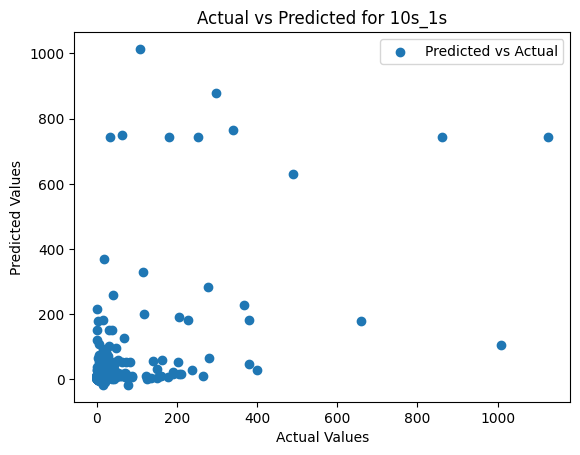

/tmp/ipykernel_30312/4045108238.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Slope: 0.5093179941177368, Correlation Coefficient: 0.5390517374729409, Tiger Score: 0.40214011561223995, MSE: 9118.4404296875
Tiger Score 98th percentile for 10s_1s: 0.7217257443552162, MSE 98th: 1938.55615234375
10s_5s


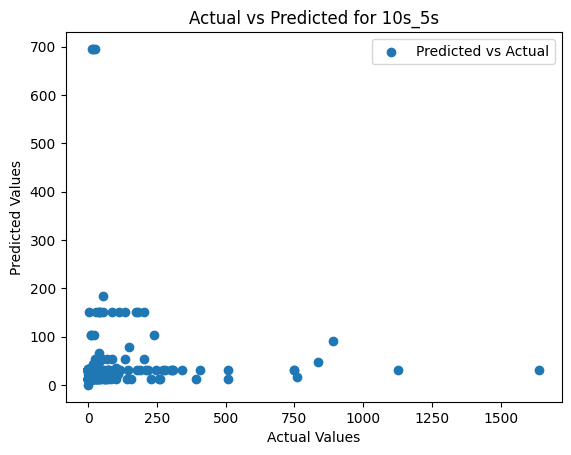

Slope: 0.37500137090682983, Correlation Coefficient: 0.049829602631498125, Tiger Score: 0.032545597080975215, MSE: 16794.8359375
Tiger Score 98th percentile for 10s_5s: 0.3518622612408343, MSE 98th: 2726.462158203125
5s_0.01s


/tmp/ipykernel_30312/4045108238.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


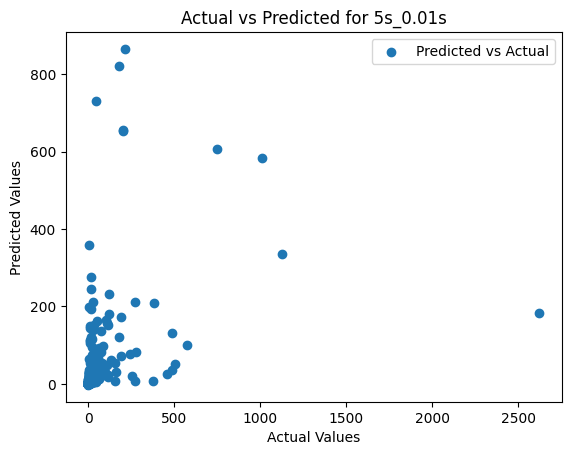

Slope: 0.6872128844261169, Correlation Coefficient: 0.39292962396391035, Tiger Score: 0.3338600240141851, MSE: 17404.92578125
Tiger Score 98th percentile for 5s_0.01s: 0.6013004284511485, MSE 98th: 1998.3299560546875
5s_0.05s


/tmp/ipykernel_30312/4045108238.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


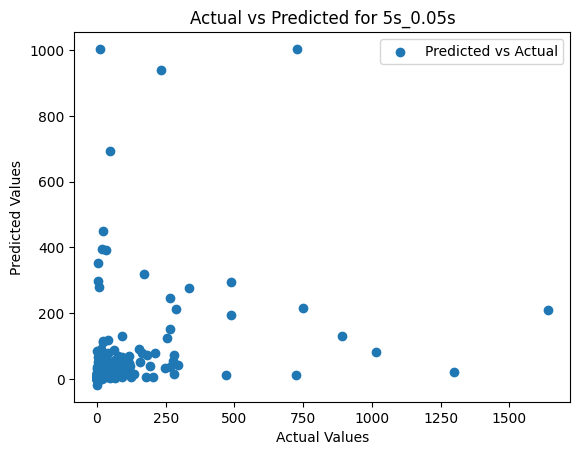

Slope: 0.5326088666915894, Correlation Coefficient: 0.32866996040866475, Tiger Score: 0.25000039042521377, MSE: 16152.0634765625
Tiger Score 98th percentile for 5s_0.05s: 0.6392067763543814, MSE 98th: 2279.725830078125
15s_0.2s


/tmp/ipykernel_30312/4045108238.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


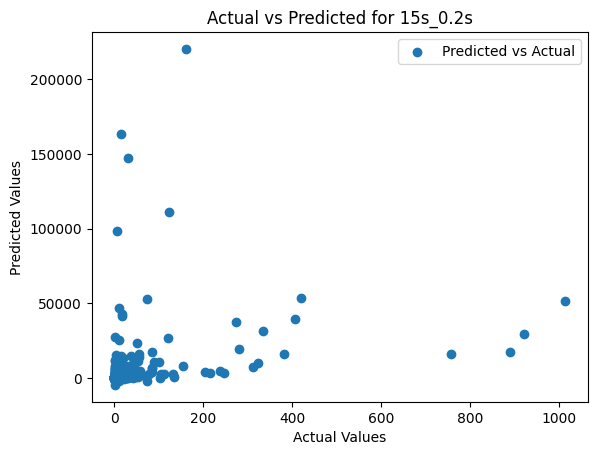

Slope: 0.0018554668640717864, Correlation Coefficient: 0.2861008956306704, Tiger Score: 0.018630457349902547, MSE: 242902544.0
Tiger Score 98th percentile for 15s_0.2s: 0.007733514796458476, MSE 98th: 19933896.0
2.5s_0.05s


/tmp/ipykernel_30312/4045108238.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


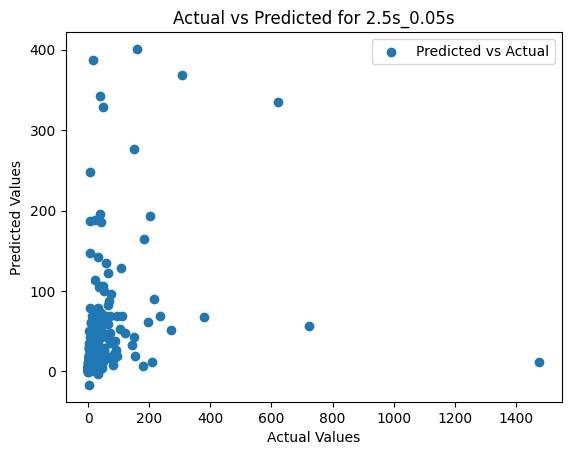

Slope: 0.6170313954353333, Correlation Coefficient: 0.30835107126618294, Tiger Score: 0.25002133087867146, MSE: 6227.93359375
Tiger Score 98th percentile for 2.5s_0.05s: 0.5695370110073358, MSE 98th: 717.2571411132812
1s_0.05s


/tmp/ipykernel_30312/4045108238.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


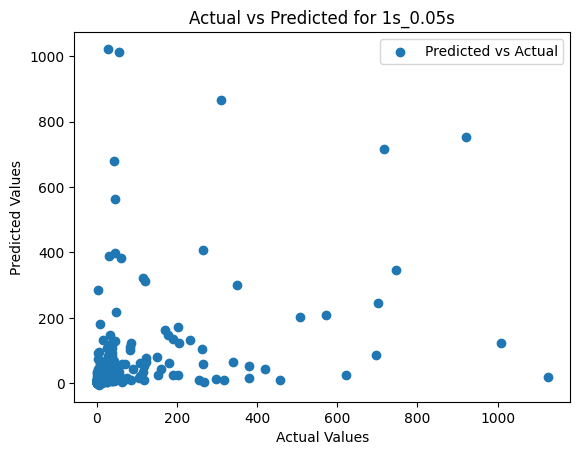

Slope: 0.5145343542098999, Correlation Coefficient: 0.39915073404877205, Tiger Score: 0.29909268300849334, MSE: 13725.7451171875
Tiger Score 98th percentile for 1s_0.05s: 0.7004458228635188, MSE 98th: 3472.304443359375
7.5s_0.05s


/tmp/ipykernel_30312/4045108238.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


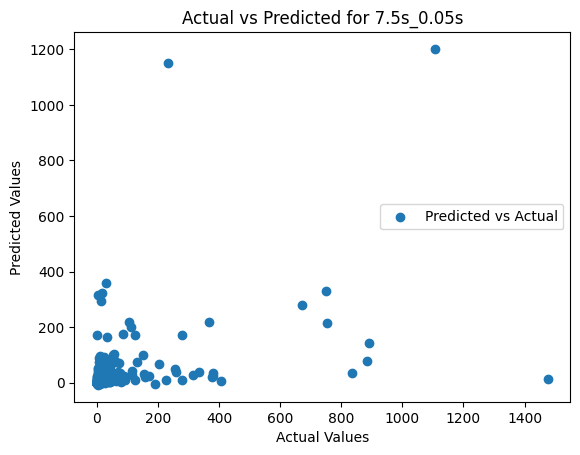

Slope: 0.7417254447937012, Correlation Coefficient: 0.45705338673729157, Tiger Score: 0.4014340985259623, MSE: 11893.953125
Tiger Score 98th percentile for 7.5s_0.05s: 0.6636487549241542, MSE 98th: 1963.1304931640625
15s_0.05s


/tmp/ipykernel_30312/4045108238.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


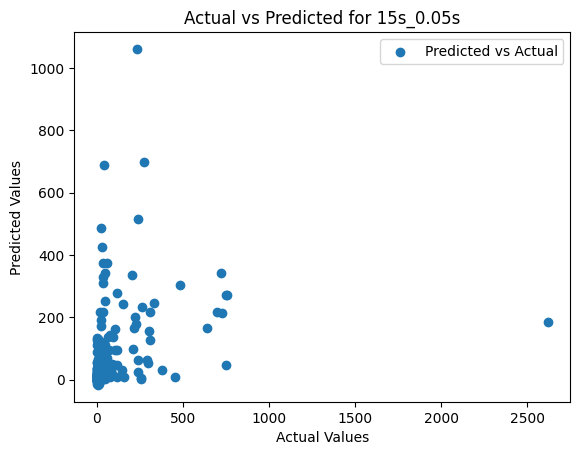

Slope: 0.6513881087303162, Correlation Coefficient: 0.3623544384661019, Tiger Score: 0.3008051373027533, MSE: 18690.064453125
Tiger Score 98th percentile for 15s_0.05s: 0.4702763117990135, MSE 98th: 3223.129150390625
2.5s_0.01s


/tmp/ipykernel_30312/4045108238.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


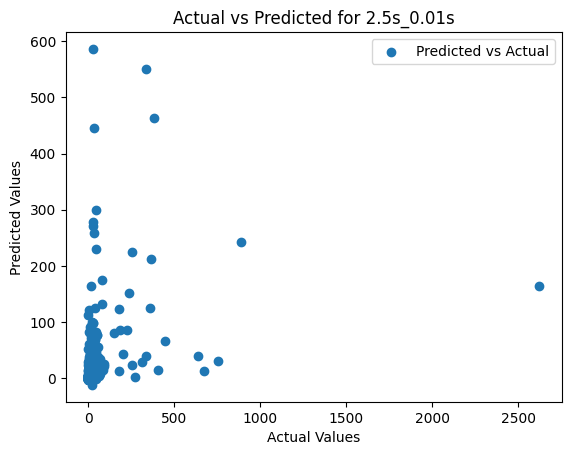

Slope: 0.8175927996635437, Correlation Coefficient: 0.31034161012729694, Tiger Score: 0.2843513771791172, MSE: 15896.603515625
Tiger Score 98th percentile for 2.5s_0.01s: 0.5201499127932799, MSE 98th: 1293.9398193359375
5s_0.2s


/tmp/ipykernel_30312/4045108238.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


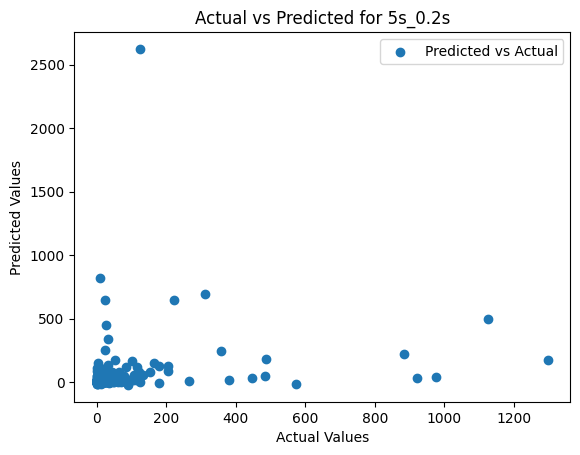

Slope: 0.2261369526386261, Correlation Coefficient: 0.22272304203161264, Tiger Score: 0.11678102161697038, MSE: 21821.9375
Tiger Score 98th percentile for 5s_0.2s: 0.4547631846076375, MSE 98th: 1944.03955078125
1s_0.01s


/tmp/ipykernel_30312/4045108238.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


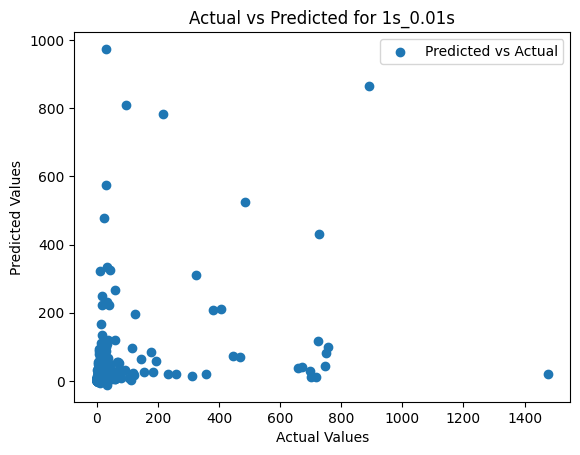

Slope: 0.5069129467010498, Correlation Coefficient: 0.3144286042388682, Tiger Score: 0.2340864332898761, MSE: 16466.236328125
Tiger Score 98th percentile for 1s_0.01s: 0.4895617679318036, MSE 98th: 4096.98291015625
10s_0.05s


/tmp/ipykernel_30312/4045108238.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


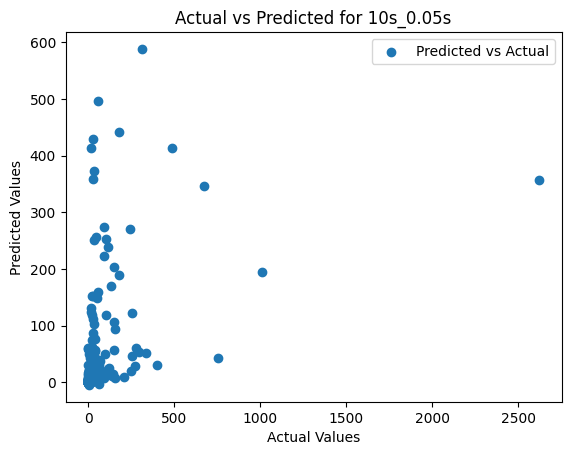

/tmp/ipykernel_30312/4045108238.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Slope: 0.9026119709014893, Correlation Coefficient: 0.4304671044307965, Tiger Score: 0.41173173043042127, MSE: 13773.3125
Tiger Score 98th percentile for 10s_0.05s: 0.5290129572430746, MSE 98th: 1433.00927734375
1s_0.2s


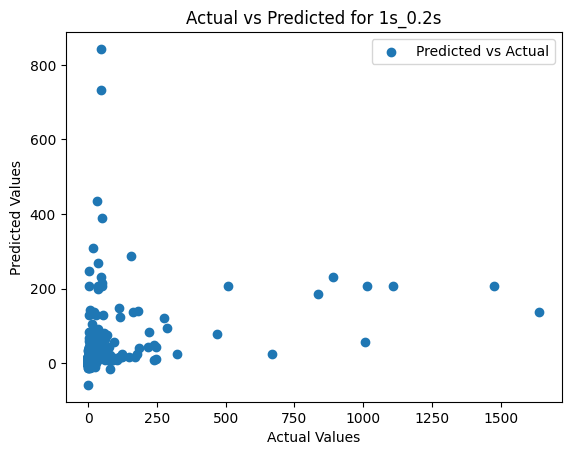

Slope: 0.7151714563369751, Correlation Coefficient: 0.3058364063499953, Tiger Score: 0.2643993136115776, MSE: 17233.52734375
Tiger Score 98th percentile for 1s_0.2s: 0.29716742661295936, MSE 98th: 2405.8095703125
7.5s_0.01s


/tmp/ipykernel_30312/4045108238.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


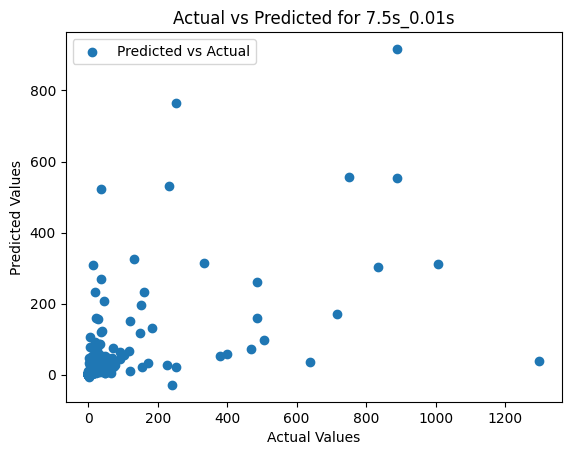

Slope: 0.9524252414703369, Correlation Coefficient: 0.6067067867699474, Tiger Score: 0.5939983359617004, MSE: 8479.318359375
Tiger Score 98th percentile for 7.5s_0.01s: 0.7676410212299567, MSE 98th: 1564.242431640625
10s_0.2s


/tmp/ipykernel_30312/4045108238.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


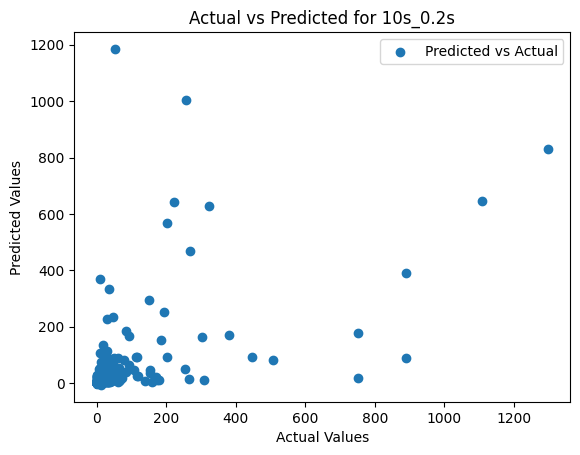

Slope: 0.6482240557670593, Correlation Coefficient: 0.5479387188253103, Tiger Score: 0.4539053052370457, MSE: 9474.6181640625
Tiger Score 98th percentile for 10s_0.2s: 0.5054631124232777, MSE 98th: 1748.8802490234375
10s_0.01s


/tmp/ipykernel_30312/4045108238.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


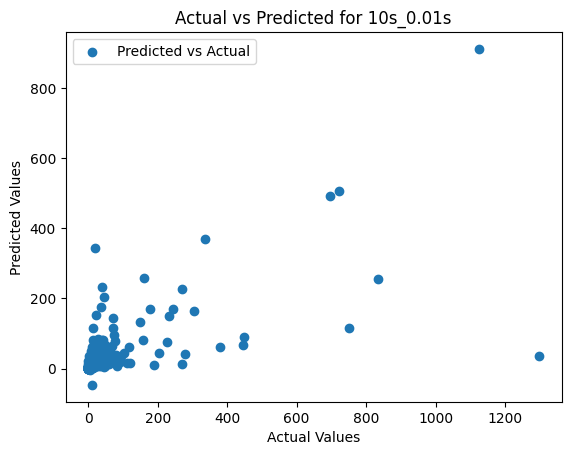

Slope: 1.2177625894546509, Correlation Coefficient: 0.6918167811372669, Tiger Score: 0.6350847949515244, MSE: 5721.02587890625
Tiger Score 98th percentile for 10s_0.01s: 0.7205317477217975, MSE 98th: 617.1658935546875


In [6]:
# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=[
    'model_name', 'total', 'delta', 'slope', 'correlation_coef', 'tiger_score', 
    'avg_abs_error', 'avg_abs_error_normalized', 'median_abs_error', 
    'median_abs_error_normalized', '98th_abs_error', '98th_avg_abs_error',
    '98th_abs_error_normalized', '98th_avg_abs_error_normalized',
    'slope_98th', 'correlation_coef_98th', 'tiger_score_98th', 'mse', 'mse_98th'
])

for filename in os.listdir('../model/models'):
    if not filename.endswith('.pt') or 'complex' in filename:
        continue

    model_name = filename[14:-3]
    print(model_name)
    
    x, y = model_name.split('_')
    total = float(x[:-1])
    delta = float(y[:-1])
    data_tensors, target_tensors, target_mean, target_std = load_and_normalize_data(model_name)
    train_dataset, test_dataset = prepare_datasets(data_tensors, target_tensors)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    input_size = len(train_dataset[0][0][0])
    hidden_size = 64
    output_size = 1
    model = RNNModel(input_size, hidden_size, output_size)
    model.load_state_dict(torch.load(f'../model/models/{filename}'))
    
    pred_denorm, targets_denorm = evaluate_model(model, test_dataset, target_mean, target_std)
    
    correlation_coef, slope = regression_through_origin_with_correlation(pred_denorm, targets_denorm)
    tiger_score_value = tiger_score(correlation_coef, slope)
    
    metrics, abs_errors = calculate_metrics(pred_denorm, targets_denorm)
    slope_98th, correlation_coef_98th, slope_98th, correlation_coef_98th, mse_98th = calculate_regression_metrics(pred_denorm, targets_denorm, abs_errors, metrics['98th_abs_error'])
    tiger_score_value_98th = tiger_score(correlation_coef_98th, slope_98th)
    
    results_df = append_results(results_df, model_name, total, delta, slope, correlation_coef, tiger_score_value, metrics, slope_98th, correlation_coef_98th, tiger_score_value_98th, mse_98th)
    
    plot_actual_vs_predicted(targets_denorm, pred_denorm, model_name)
    
    print(f'Slope: {slope}, Correlation Coefficient: {correlation_coef}, Tiger Score: {tiger_score_value}, MSE: {metrics["mse"]}')
    print(f'Tiger Score 98th percentile for {model_name}: {tiger_score_value_98th}, MSE 98th: {mse_98th}')

results_df.to_csv('model_evaluation_results.csv', index=False)

In [7]:
# for each total time [1, 2.5, 5, 7.5, 10], get a function to compute the mean throughput for that slot by summing the products of the mean packet size and the number of packets


In [8]:
print(results_df)

    model_name  total  delta     slope  correlation_coef  tiger_score  \
0       10s_1s   10.0   1.00  0.509318          0.539052     0.402140   
1       10s_5s   10.0   5.00  0.375001          0.049830     0.032546   
2     5s_0.01s    5.0   0.01  0.687213          0.392930     0.333860   
3     5s_0.05s    5.0   0.05  0.532609          0.328670     0.250000   
4     15s_0.2s   15.0   0.20  0.001855          0.286101     0.018630   
5   2.5s_0.05s    2.5   0.05  0.617031          0.308351     0.250021   
6     1s_0.05s    1.0   0.05  0.514534          0.399151     0.299093   
7   7.5s_0.05s    7.5   0.05  0.741725          0.457053     0.401434   
8    15s_0.05s   15.0   0.05  0.651388          0.362354     0.300805   
9   2.5s_0.01s    2.5   0.01  0.817593          0.310342     0.284351   
10     5s_0.2s    5.0   0.20  0.226137          0.222723     0.116781   
11    1s_0.01s    1.0   0.01  0.506913          0.314429     0.234086   
12   10s_0.05s   10.0   0.05  0.902612          0.4

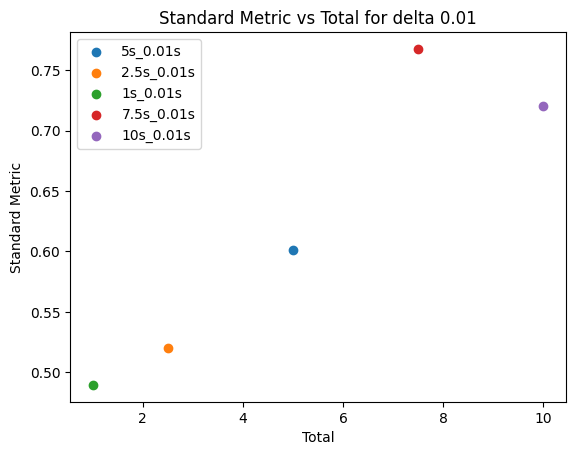

In [9]:
# plot for each of the models with delta 0.01, plot the standard metric vs the total
plt.figure()
for index, row in results_df.iterrows():
    if row['delta'] == 0.01:
        plt.scatter(row['total'], row['tiger_score_98th'], label=row['model_name'])
plt.xlabel('Total')
plt.ylabel('Standard Metric')
plt.title('Standard Metric vs Total for delta 0.01')
plt.legend()
plt.show()


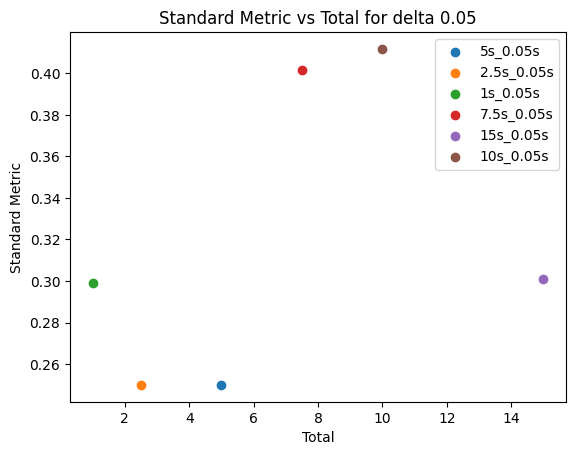

In [10]:
# plot for each of the models with delta 0.05, plot the standard metric vs the total
plt.figure()
for index, row in results_df.iterrows():
    if row['delta'] == 0.05:
        plt.scatter(row['total'], row['tiger_score'], label=row['model_name'])
plt.xlabel('Total')
plt.ylabel('Standard Metric')
plt.title('Standard Metric vs Total for delta 0.05')
plt.legend()


In [11]:
# filter the dataframe to only include models with total 5
results_df_total_5 = results_df[results_df['total'] == 5]

# get the row with the maximum standard metric
max_standard_metric_row = results_df_total_5.loc[results_df_total_5['tiger_score'].idxmax()]

max_standard_metric_row

model_name                           5s_0.01s
total                                     5.0
delta                                    0.01
slope                                0.687213
correlation_coef                      0.39293
tiger_score                           0.33386
avg_abs_error                       28.681581
avg_abs_error_normalized           188.833832
median_abs_error                      1.78178
median_abs_error_normalized         59.900345
98th_abs_error                      370.96485
98th_avg_abs_error                  15.088804
98th_abs_error_normalized         1316.268689
98th_avg_abs_error_normalized       126.11097
slope_98th                           0.612445
correlation_coef_98th                 0.74399
tiger_score_98th                       0.6013
mse                              17404.925781
mse_98th                          1998.329956
Name: 2, dtype: object

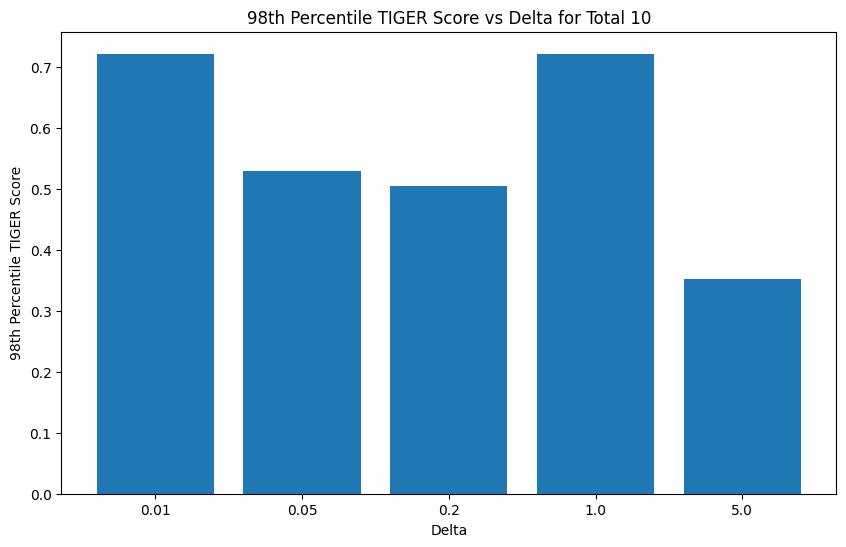

In [12]:
# Filter and sort the DataFrame by 'delta'
subset = results_df[results_df['total'] == 10].sort_values(by='delta')

# Extract the sorted values
deltas = subset['delta'].astype(str)
standard_metrics = subset['tiger_score_98th']

# Create the bar graph
plt.figure(figsize=(10, 6))
plt.bar(deltas, standard_metrics)

# Set the x-axis and y-axis labels and title
plt.xlabel('Delta')
plt.ylabel('98th Percentile TIGER Score')
plt.title('98th Percentile TIGER Score vs Delta for Total 10')

# Show the plot without a legend
plt.show()

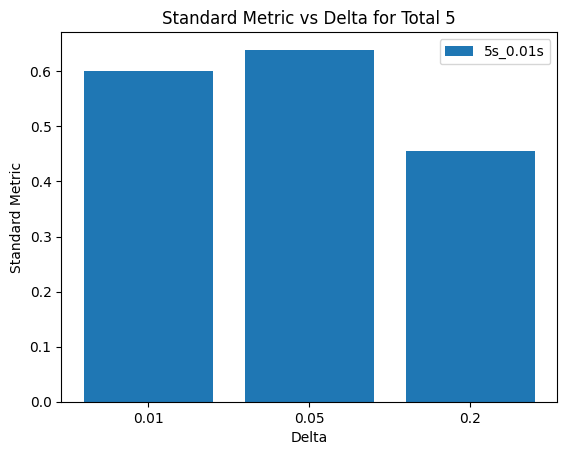

In [13]:
# Filter and sort the DataFrame by 'delta'
subset = results_df[results_df['total'] == 5].sort_values(by='delta')

# Extract the sorted values
deltas = subset['delta'].astype(str)
standard_metrics = subset['tiger_score_98th']
model_names = subset['model_name']

# Create the bar graph
plt.figure()
plt.bar(deltas, standard_metrics)

# Set the x-axis and y-axis labels and title
plt.xlabel('Delta')
plt.ylabel('Standard Metric')
plt.title('Standard Metric vs Delta for Total 5')

# Add a legend
plt.legend(model_names, loc='best')

# Show the plot
plt.show()

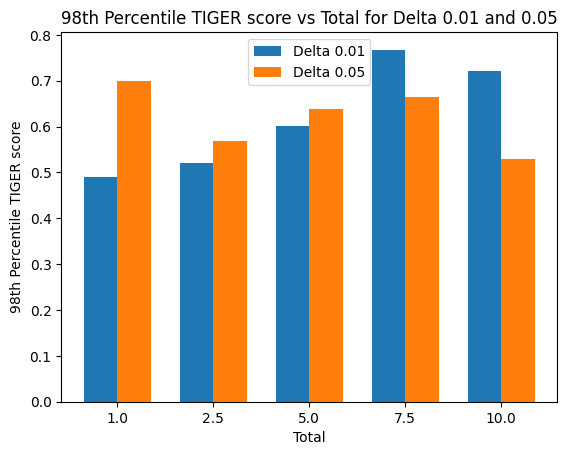

In [14]:
# Filter the DataFrame by 'delta' values
subset_0_01 = results_df[results_df['delta'] == 0.01][['total', 'tiger_score_98th']].rename(columns={'tiger_score_98th': 'metric_0_01'})
subset_0_05 = results_df[results_df['delta'] == 0.05][['total', 'tiger_score_98th']].rename(columns={'tiger_score_98th': 'metric_0_05'})

# Merge the subsets on 'total'
merged_df = pd.merge(subset_0_01, subset_0_05, on='total').sort_values(by='total')

# Extract the sorted values
totals = merged_df['total'].astype(str)
standard_metrics_0_01 = merged_df['metric_0_01']
standard_metrics_0_05 = merged_df['metric_0_05']

# Create the bar graph
plt.figure()

# Define bar width and positions
bar_width = 0.35
index = np.arange(len(totals))

# Plot bars for delta 0.01 and 0.05
plt.bar(index, standard_metrics_0_01, bar_width, label='Delta 0.01')
plt.bar(index + bar_width, standard_metrics_0_05, bar_width, label='Delta 0.05')

# Set the x-axis and y-axis labels and title
plt.xlabel('Total')
plt.ylabel('98th Percentile TIGER score')
plt.title('98th Percentile TIGER score vs Total for Delta 0.01 and 0.05')

# Set the x-ticks and labels
plt.xticks(index + bar_width / 2, totals)

# Add a legend
plt.legend(loc='best')

# Show the plot
plt.show()

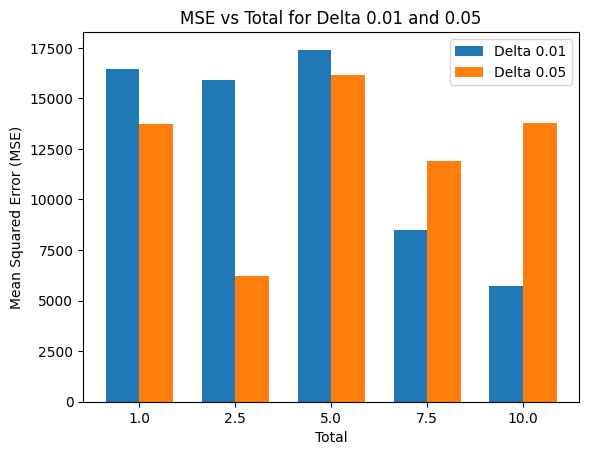

In [15]:
# Filter the DataFrame by 'delta' values
subset_0_01_mse = results_df[results_df['delta'] == 0.01][['total', 'mse']].rename(columns={'mse': 'mse_0_01'})
subset_0_05_mse = results_df[results_df['delta'] == 0.05][['total', 'mse']].rename(columns={'mse': 'mse_0_05'})

# Merge the subsets on 'total'
merged_df_mse = pd.merge(subset_0_01_mse, subset_0_05_mse, on='total').sort_values(by='total')

# Extract the sorted values
totals_mse = merged_df_mse['total'].astype(str)
mse_0_01 = merged_df_mse['mse_0_01']
mse_0_05 = merged_df_mse['mse_0_05']

# Create the bar graph for MSE
plt.figure()

# Define bar width and positions
bar_width = 0.35
index = np.arange(len(totals_mse))

# Plot bars for delta 0.01 and 0.05
plt.bar(index, mse_0_01, bar_width, label='Delta 0.01')
plt.bar(index + bar_width, mse_0_05, bar_width, label='Delta 0.05')

# Set the x-axis and y-axis labels and title
plt.xlabel('Total')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs Total for Delta 0.01 and 0.05')

# Set the x-ticks and labels
plt.xticks(index + bar_width / 2, totals_mse)

# Add a legend
plt.legend(loc='best')

# Show the plot
plt.show()


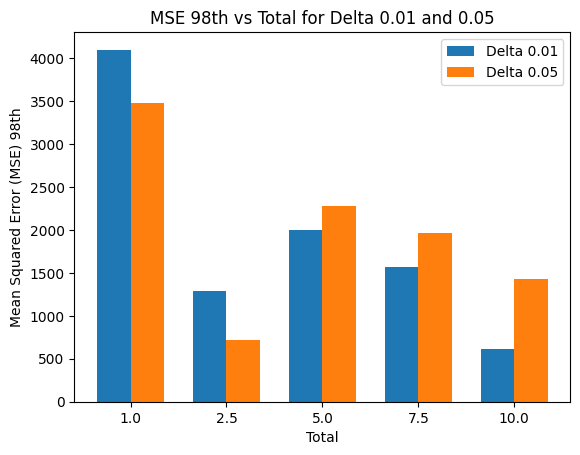

In [16]:
# Filter the DataFrame by 'delta' values
subset_0_01_mse = results_df[results_df['delta'] == 0.01][['total', 'mse_98th']].rename(columns={'mse_98th': 'mse_98th_0_01'})
subset_0_05_mse = results_df[results_df['delta'] == 0.05][['total', 'mse_98th']].rename(columns={'mse_98th': 'mse_98th_0_05'})

# Merge the subsets on 'total'
merged_df_mse = pd.merge(subset_0_01_mse, subset_0_05_mse, on='total').sort_values(by='total')

# Extract the sorted values
totals_mse = merged_df_mse['total'].astype(str)
mse_0_01 = merged_df_mse['mse_98th_0_01']
mse_0_05 = merged_df_mse['mse_98th_0_05']

# Create the bar graph for MSE
plt.figure()

# Define bar width and positions
bar_width = 0.35
index = np.arange(len(totals_mse))

# Plot bars for delta 0.01 and 0.05
plt.bar(index, mse_0_01, bar_width, label='Delta 0.01')
plt.bar(index + bar_width, mse_0_05, bar_width, label='Delta 0.05')

# Set the x-axis and y-axis labels and title
plt.xlabel('Total')
plt.ylabel('Mean Squared Error (MSE) 98th')
plt.title('MSE 98th vs Total for Delta 0.01 and 0.05')

# Set the x-ticks and labels
plt.xticks(index + bar_width / 2, totals_mse)

# Add a legend
plt.legend(loc='best')

# Show the plot
plt.show()


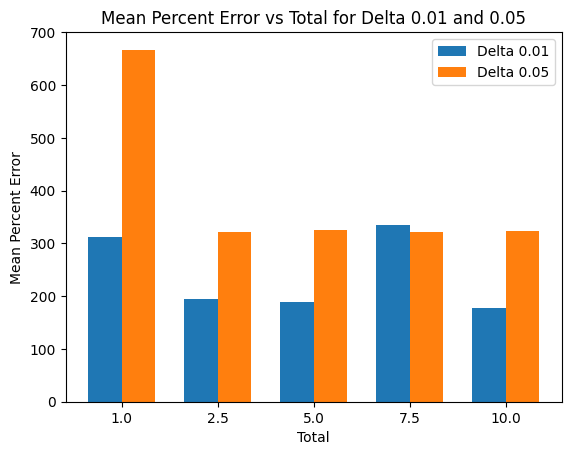

In [17]:
# Filter the DataFrame by 'delta' values for mean percent error
subset_0_01_mean_percent_error = results_df[results_df['delta'] == 0.01][['total', 'avg_abs_error_normalized']].rename(columns={'avg_abs_error_normalized': 'mean_percent_error_0_01'})
subset_0_05_mean_percent_error = results_df[results_df['delta'] == 0.05][['total', 'avg_abs_error_normalized']].rename(columns={'avg_abs_error_normalized': 'mean_percent_error_0_05'})

# Merge the subsets on 'total'
merged_df_mean_percent_error = pd.merge(subset_0_01_mean_percent_error, subset_0_05_mean_percent_error, on='total').sort_values(by='total')

# Extract the sorted values
totals_mean_percent_error = merged_df_mean_percent_error['total'].astype(str)
mean_percent_error_0_01 = merged_df_mean_percent_error['mean_percent_error_0_01']
mean_percent_error_0_05 = merged_df_mean_percent_error['mean_percent_error_0_05']

# Create the bar graph for Mean Percent Error
plt.figure()

# Define bar width and positions
bar_width = 0.35
index = np.arange(len(totals_mean_percent_error))

# Plot bars for delta 0.01 and 0.05
plt.bar(index, mean_percent_error_0_01, bar_width, label='Delta 0.01')
plt.bar(index + bar_width, mean_percent_error_0_05, bar_width, label='Delta 0.05')

# Set the x-axis and y-axis labels and title
plt.xlabel('Total')
plt.ylabel('Mean Percent Error')
plt.title('Mean Percent Error vs Total for Delta 0.01 and 0.05')

# Set the x-ticks and labels
plt.xticks(index + bar_width / 2, totals_mean_percent_error)

# Add a legend
plt.legend(loc='best')

# Show the plot
plt.show()


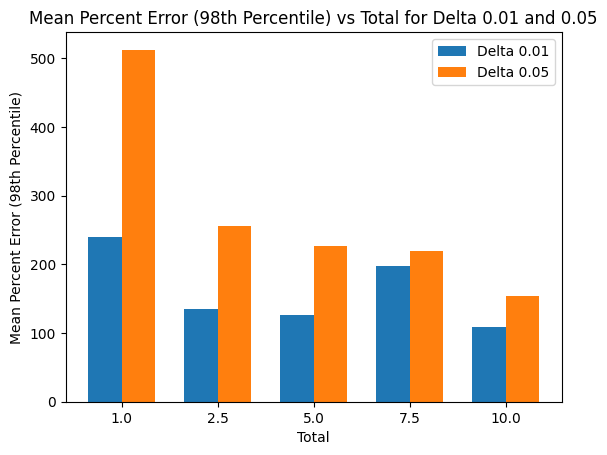

In [18]:
# Filter the DataFrame by 'delta' values for mean percent error (98th percentile)
subset_0_01_mean_percent_error_98th = results_df[results_df['delta'] == 0.01][['total', '98th_avg_abs_error_normalized']].rename(columns={'98th_avg_abs_error_normalized': 'mean_percent_error_98th_0_01'})
subset_0_05_mean_percent_error_98th = results_df[results_df['delta'] == 0.05][['total', '98th_avg_abs_error_normalized']].rename(columns={'98th_avg_abs_error_normalized': 'mean_percent_error_98th_0_05'})

# Merge the subsets on 'total'
merged_df_mean_percent_error_98th = pd.merge(subset_0_01_mean_percent_error_98th, subset_0_05_mean_percent_error_98th, on='total').sort_values(by='total')

# Extract the sorted values
totals_mean_percent_error_98th = merged_df_mean_percent_error_98th['total'].astype(str)
mean_percent_error_98th_0_01 = merged_df_mean_percent_error_98th['mean_percent_error_98th_0_01']
mean_percent_error_98th_0_05 = merged_df_mean_percent_error_98th['mean_percent_error_98th_0_05']

# Create the bar graph for Mean Percent Error (98th percentile)
plt.figure()

# Define bar width and positions
bar_width = 0.35
index = np.arange(len(totals_mean_percent_error_98th))

# Plot bars for delta 0.01 and 0.05
plt.bar(index, mean_percent_error_98th_0_01, bar_width, label='Delta 0.01')
plt.bar(index + bar_width, mean_percent_error_98th_0_05, bar_width, label='Delta 0.05')

# Set the x-axis and y-axis labels and title
plt.xlabel('Total')
plt.ylabel('Mean Percent Error (98th Percentile)')
plt.title('Mean Percent Error (98th Percentile) vs Total for Delta 0.01 and 0.05')

# Set the x-ticks and labels
plt.xticks(index + bar_width / 2, totals_mean_percent_error_98th)

# Add a legend
plt.legend(loc='best')

# Show the plot
plt.show()


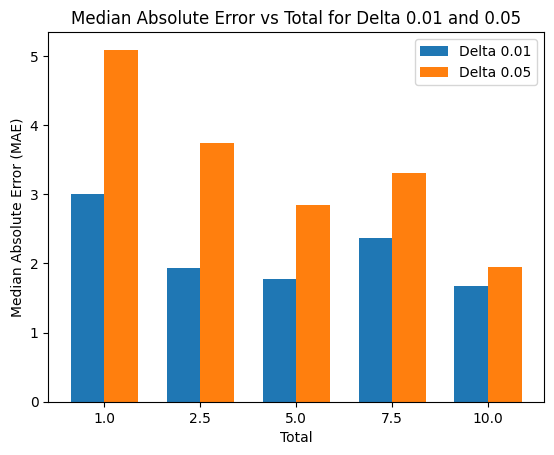

In [19]:
# Filter the DataFrame by 'delta' values
subset_0_01_mae = results_df[results_df['delta'] == 0.01][['total', 'median_abs_error']].rename(columns={'median_abs_error': 'mae_0_01'})
subset_0_05_mae = results_df[results_df['delta'] == 0.05][['total', 'median_abs_error']].rename(columns={'median_abs_error': 'mae_0_05'})

# Merge the subsets on 'total'
merged_df_mae = pd.merge(subset_0_01_mae, subset_0_05_mae, on='total').sort_values(by='total')

# Extract the sorted values
totals_mae = merged_df_mae['total'].astype(str)
mae_0_01 = merged_df_mae['mae_0_01']
mae_0_05 = merged_df_mae['mae_0_05']

# Create the bar graph for Median Absolute Error
plt.figure()

# Define bar width and positions
bar_width = 0.35
index = np.arange(len(totals_mae))

# Plot bars for delta 0.01 and 0.05
plt.bar(index, mae_0_01, bar_width, label='Delta 0.01')
plt.bar(index + bar_width, mae_0_05, bar_width, label='Delta 0.05')

# Set the x-axis and y-axis labels and title
plt.xlabel('Total')
plt.ylabel('Median Absolute Error (MAE)')
plt.title('Median Absolute Error vs Total for Delta 0.01 and 0.05')

# Set the x-ticks and labels
plt.xticks(index + bar_width / 2, totals_mae)

# Add a legend
plt.legend(loc='best')

# Show the plot
plt.show()


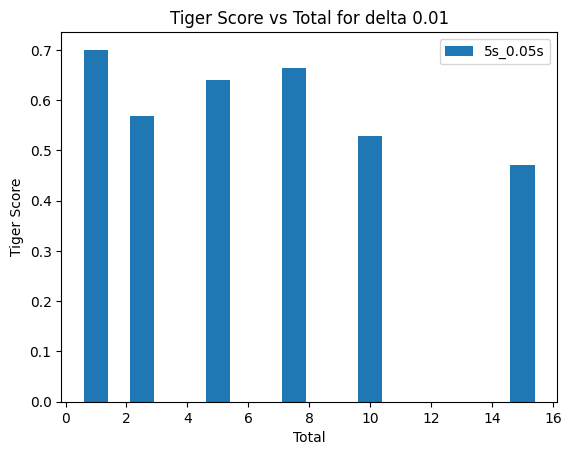

In [20]:
plt.figure()

# Filter the DataFrame by delta 0.01
subset = results_df[results_df['delta'] == 0.05]

# Extract the total and standard metric values
totals = subset['total']
standard_metrics = subset['tiger_score_98th']
model_names = subset['model_name']

# Create the bar graph
plt.bar(totals, standard_metrics)

# Set the x-axis and y-axis labels and title
plt.xlabel('Total')
plt.ylabel('Tiger Score')
plt.title('Tiger Score vs Total for delta 0.01')

# Add a legend
plt.legend(model_names, loc='best')

# Show the plot
plt.show()


In [21]:
# get the row for 7.5s_0.01s
results_df[(results_df['total'] == 7.5) & (results_df['delta'] == 0.01)]

,model_name,total,delta,slope,correlation_coef,tiger_score,avg_abs_error,avg_abs_error_normalized,median_abs_error,median_abs_error_normalized,98th_abs_error,98th_avg_abs_error,98th_abs_error_normalized,98th_avg_abs_error_normalized,slope_98th,correlation_coef_98th,tiger_score_98th,mse,mse_98th
14,7.5s_0.01s,7.5,0.01,0.952425,0.606707,0.593998,23.601318,335.090027,2.36745,68.757416,326.556734,13.130545,2150.798623,198.170029,0.79974,0.845877,0.767641,8479.318359,1564.242432


### Have a model that can predict the result of a speedtest based on 7.5 seconds of data with a median error of 2.37 Mbps or a median error of 68.8%, with 98th percentile average is 13.13% This model scores 59.3% on the standard metric and a 78.8% on the 98th percentile standard metric! For the 98th percentile metric, the model has slope of 0.8 and correlation coeff of 0.846 showing that the model tends to under guess.